In [18]:
%load_ext autoreload
%autoreload 2

import cleanlab
from cleanlab.rank import get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.internal.label_quality_utils import get_normalized_entropy
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, log_loss
from matplotlib import pyplot as plt
import copy
from PIL import Image
from IPython.display import HTML
import math
import glob
import random
import base64
from io import BytesIO
import warnings
from autogluon.vision import ImagePredictor, ImageDataset

sys.path.insert(0, "../")
from eval_metrics import lift_at_k
from active_learning_scores import least_confidence

from approximate_nearest_neighbors import ApproxNearestNeighbors

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((200, 200), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

# convert your links to html tags 
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

## Read data

In [3]:
model = "swin_base_patch4_window7_224"

#### Andrew Ng DCAI Roman Numerals ####

# read numpy files
numpy_out_folder = f"../roman-numeral/roman-numeral_train_val_dataset_cv_{model}/"
pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
labels = np.load(numpy_out_folder + "labels.npy")
images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)
label_errors_mask = np.load(numpy_out_folder + "label_errors_mask.npy")

In [60]:
pred_probs.shape

(2831, 10)

In [5]:
# ground-truth label errors
label_errors_mask.sum()

372

## Read annotations

In [6]:
df_roman_numeral_annotations = pd.read_csv("andrew-ng-dcai-comp-2021-manual-review-for-label-errors - Data.csv")
df_roman_numeral_annotations["short_file_paths"] = df_roman_numeral_annotations.file_path
df_roman_numeral_annotations.head(3)

,image,label_error,action,given_label,corrected_label,file_path,image_public_url,short_file_paths
0,NaN,True,Fix Data Label,i,ii,train/i/abf15a58-ce5d-11eb-b317-38f9d35ea60f.png,https://worksheets.codalab.org/rest/bundles/0x497f5d7096724783aa1eb78b85aa321f/contents/blob/andrew-ng-dcai-comp-2021-data/train/i/abf15a58-ce5d-11eb-b317-38f9d35ea60f.png,train/i/abf15a58-ce5d-11eb-b317-38f9d35ea60f.png
1,NaN,True,Fix Data Label,i,x,train/i/ac14e8ba-ce5d-11eb-b317-38f9d35ea60f.png,https://worksheets.codalab.org/rest/bundles/0x497f5d7096724783aa1eb78b85aa321f/contents/blob/andrew-ng-dcai-comp-2021-data/train/i/ac14e8ba-ce5d-11eb-b317-38f9d35ea60f.png,train/i/ac14e8ba-ce5d-11eb-b317-38f9d35ea60f.png
2,NaN,True,Fix Data Label,i,iii,train/i/ac156ed4-ce5d-11eb-b317-38f9d35ea60f.png,https://worksheets.codalab.org/rest/bundles/0x497f5d7096724783aa1eb78b85aa321f/contents/blob/andrew-ng-dcai-comp-2021-data/train/i/ac156ed4-ce5d-11eb-b317-38f9d35ea60f.png,train/i/ac156ed4-ce5d-11eb-b317-38f9d35ea60f.png


## Find label issues with cleanlab

In [7]:
pred_label_issues_mask = cleanlab.filter.find_label_issues(labels, pred_probs, filter_by="prune_by_class")
pred_label_issues_mask.sum()

158

In [8]:
label_errors_mask.sum()

372

## Prepare data

In [25]:
df = pd.DataFrame({
    "images": images,
    "labels": labels,
    "pred_label_issues_mask": pred_label_issues_mask,
    "label_errors_target": label_errors_mask
})

prefix = "/Data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/" # path to dataset
df["file_paths"] = df.images.map(lambda x: prefix + "/".join(Path(x).parts[-3:]))
df["display_image"] = df.file_paths.map(lambda f: get_thumbnail(f))
df["short_file_paths"] = df.file_paths.map(lambda x: "/".join(Path(x).parts[-3:]))

df["label_name"] = df.file_paths.map(lambda x: Path(x).parts[-2])

# add "actions" column from annotations
df = df.merge(df_roman_numeral_annotations[["short_file_paths", "action"]], how="left", on="short_file_paths")

In [10]:
df.head(3)

,images,labels,pred_label_issues_mask,label_errors_target,file_paths,display_image,short_file_paths,label_name,action
0,/dcai/data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/train/i/ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png,0,False,False,/Data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/train/i/ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png,<PIL.PngImagePlugin.PngImageFile image mode=L size=200x200 at 0x7FC5F41A3310>,train/i/ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png,i,Keep Data
1,/dcai/data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/train/i/aba24486-ce5d-11eb-b317-38f9d35ea60f.png,0,False,False,/Data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/train/i/aba24486-ce5d-11eb-b317-38f9d35ea60f.png,<PIL.PngImagePlugin.PngImageFile image mode=L size=200x156 at 0x7FC5F41A3220>,train/i/aba24486-ce5d-11eb-b317-38f9d35ea60f.png,i,Keep Data
2,/dcai/data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/train/i/aba35128-ce5d-11eb-b317-38f9d35ea60f.png,0,False,False,/Data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/train/i/aba35128-ce5d-11eb-b317-38f9d35ea60f.png,<PIL.PngImagePlugin.PngImageFile image mode=L size=188x200 at 0x7FC5F41A3190>,train/i/aba35128-ce5d-11eb-b317-38f9d35ea60f.png,i,Keep Data


In [11]:
df.shape

(2831, 9)

## Load model and extract features

In [12]:
# create "image" and "label" column with file path for AutoGluon
df_model_input = pd.DataFrame({"label": labels})
df_model_input["image"] = pd.Series(images).map(lambda f: "/Data/" + "/".join(Path(f).parts[-5:]))
df_model_input.head(2)

,label,image
0,0,/Data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/train/i/ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png
1,0,/Data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/train/i/aba24486-ce5d-11eb-b317-38f9d35ea60f.png


In [13]:
# model path for 1 fold of CV
model_path = "./dcai_train_val_dataset_cv_swin_base_patch4_window7_224/split_0/predictor.ag"

# load model
print("Loading model...")
predictor_loaded = ImagePredictor.load(model_path)

Loading model...


In [14]:
print("Extracting features...")
features = \
    np.stack(
        predictor_loaded.predict_feature(data=df_model_input, as_pandas=False)[:, 0]
    )

Extracting features...


In [16]:
features.shape

(2831, 1024)

## KNN search

In [19]:
print("  Running nearest neighbors search...")
#### Compute nearest neighbors
nns = ApproxNearestNeighbors(
        features=features, 
        labels=labels,
        ) # init Nearest Neighbor Scorer
nns.build_index() # build index for nearest neighbor lookup

neighbors_idx, neighbors_dist, neighbors_labels, neighbors_weights = nns.get_k_nearest_neighbors(k=10)

  Running nearest neighbors search...
Building nearest neighbors index


## Score data

In [26]:
# roman-numeral label names
label_names = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]


top2_pred_probs = np.sort(pred_probs, axis=1)[:, -2:][:, ::-1]
p0, p1 = top2_pred_probs[:, 0], top2_pred_probs[:, 1]


entropy = get_normalized_entropy(pred_probs)

# update DataFrame
df["top1_pred"] = p0
df["top2_pred"] = p1
df["self_confidence"] = get_label_quality_scores(labels, pred_probs, method="self_confidence")
df["normalized_margin"] = get_label_quality_scores(labels, pred_probs, method="normalized_margin")
df["confidence_weighted_entropy"] = get_label_quality_scores(labels, pred_probs, method="confidence_weighted_entropy")
df["entropy"] = entropy
df["top2_entropy"] = get_normalized_entropy(top2_pred_probs / top2_pred_probs.sum(axis=1)[:, None])
df["top1_pred_label"] = np.vectorize(lambda idx: label_names[idx])(pred_probs.argmax(axis=1))


get_neighbor_entropy = np.vectorize(lambda idx: df.entropy.values[idx])

k = 10
df["knn_k10_entropy"] = (get_neighbor_entropy(neighbors_idx[:,:k]).sum(axis=1) + df.entropy.values) / (k + 1)

df.head(1)

,images,labels,pred_label_issues_mask,label_errors_target,file_paths,display_image,short_file_paths,label_name,action,top1_pred,top2_pred,self_confidence,normalized_margin,confidence_weighted_entropy,entropy,top2_entropy,top1_pred_label,knn_k10_entropy
0,/dcai/data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/train/i/ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png,0,False,False,/Data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/train/i/ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png,<PIL.PngImagePlugin.PngImageFile image mode=L size=200x200 at 0x7FC5F42BB9A0>,train/i/ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png,i,Keep Data,0.966221,0.011509,0.966221,0.977356,0.955193,0.092045,0.092318,i,0.156803


In [27]:
columns = [
    # "top1_pred",
    # "top2_pred",    
    # "top2_entropy",
    # "correctable_score",
    # "self_confidence",
    # "normalized_margin",
    # "confidence_weighted_entropy",
    # "entropy",
    "display_image",
    "label_errors_target",
    "action",
    "correctable",
    "ood",
    # "file_paths",
    "label_name",
    "top1_pred_label",
]

In [28]:
avg_entropy_per_class = np.array(
    [np.mean(entropy[labels == k]) for k in range(pred_probs.shape[1])]
)

In [29]:
avg_entropy_per_class

array([0.26696488, 0.40346259, 0.41926852, 0.43045074, 0.3715463 ,
       0.46441901, 0.44632777, 0.32691741, 0.3601305 , 0.33584734])

<AxesSubplot:ylabel='Frequency'>

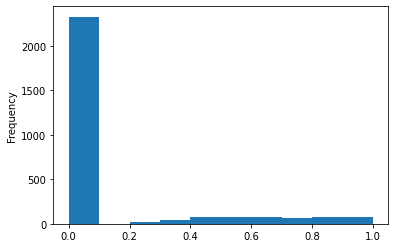

In [31]:
pred_probs_gt_self_mask = pred_probs > df.self_confidence.values[:, None]
pd.Series((pred_probs * pred_probs_gt_self_mask).sum(axis=1)).plot(kind="hist")

In [ ]:
# sum of pred_prob greater than self_confidence
# pred_probs_gt_self_mask = pred_probs > df.self_confidence.values[:, None]
# df["correctable_score"] = (pred_probs * pred_probs_gt_self_mask).sum(axis=1)
# df["correctable_score"] = (pred_probs * pred_probs_gt_self_mask).sum(axis=1)

In [32]:
# entropy excluding top label pred
pred_probs_excl_top = np.sort(pred_probs, axis=1)[:, :(pred_probs.shape[1] - 1)] # exclude top pred
pred_probs_excl_top /= pred_probs_excl_top.sum(axis=1)[:, None]
entropy_pred_probs_excl_top = get_normalized_entropy(pred_probs_excl_top)

In [33]:
pred_probs_excl_top[0]

array([0.02780164, 0.02872106, 0.05721596, 0.06546424, 0.07765306,
       0.08670875, 0.15057078, 0.16514798, 0.34071652])

In [34]:
np.sort(pred_probs[0])

array([9.39106510e-04, 9.70163324e-04, 1.93268748e-03, 2.21130461e-03,
       2.62302835e-03, 2.92891893e-03, 5.08610252e-03, 5.57850301e-03,
       1.15090003e-02, 9.66221213e-01])

In [80]:
# analyze statistics of scores by action


# df["correctable_score"] = df.top1_pred - df.top2_pred
# df["correctable_score"] = df.normalized_margin - df.normalized_margin.mean() + 1
# df["correctable_score"] = (df.top2_pred - df.top2_pred.mean()) * (df.top1_pred / df.top2_pred) + 1
# df["correctable_score"] = (top2_entropy / entropy) * (df.top1_pred - df.top2_pred)
# df["correctable_score"] = (1 / entropy) * (1 - df.normalized_margin)
# df["correctable_score"] = (top2_entropy / entropy) * (1 - df.self_confidence)
# df["correctable_score"] = (1 / entropy) * (1 - df.self_confidence)
# df["correctable_score"] = (df.top1_pred / entropy)

# df["correctable_score"] = (1 / entropy_pred_probs_excl_top) * (1 - df.normalized_margin)
# df["correctable_score"] = (1 / entropy_pred_probs_excl_top) * (1 - df.self_confidence)
# df["correctable_score"] = (top2_entropy / entropy) * (1 - df.normalized_margin)
# df["correctable_score"] = df.top1_pred / df.self_confidence
# df["correctable_score"] = (df.top2_entropy / entropy)

mass_above_given_label = np.sum(np.clip(pred_probs - df.self_confidence.values[:,np.newaxis], a_min=0, a_max=None), axis=1)
df["correctable_score"] = mass_above_given_label / entropy_pred_probs_excl_top
# df["correctable_score"] = mass_above_given_label / entropy
# df["correctable_score"] = 1 / entropy_pred_probs_excl_top


# df["ood_score"] = (entropy - np.vectorize(lambda idx: avg_entropy_per_class[idx])(labels))

df["ood_score"] = df.knn_k10_entropy


avg_correctable_score_per_class = np.array(
    [np.mean(df.correctable_score.values[labels == k]) for k in range(pred_probs.shape[1])]
)

avg_ood_score_per_class = np.array(
    [np.mean(df.ood_score.values[labels == k]) for k in range(pred_probs.shape[1])]
)



df[df.pred_label_issues_mask].groupby("action").agg(
    num_obs=("file_paths", len),
    avg_entropy=("entropy", "mean"),
    avg_knn_k10_entropy=("knn_k10_entropy", "mean"),    
    avg_top1_pred=("top1_pred", "mean"),    
    avg_normalized_margin=("normalized_margin", "mean"),
    avg_self_confidence=("self_confidence", "mean"),
    avg_confidence_weighted_entropy=("confidence_weighted_entropy", "mean"), 
    avg_correctable_score=("correctable_score", "mean"),
    avg_ood_score=("ood_score", "mean"),    
    avg_top2_entropy=("top2_entropy", "mean"),
).T

action,Fix Data Label,Keep Data,Remove Bad Data
num_obs,45.000000,54.000000,59.000000
avg_entropy,0.550208,0.555648,0.651666
avg_knn_k10_entropy,0.486045,0.470998,0.548212
avg_top1_pred,0.593762,0.587072,0.505049
avg_normalized_margin,0.222908,0.238933,0.268378
avg_self_confidence,0.039578,0.064938,0.041804
avg_confidence_weighted_entropy,0.192361,0.258899,0.170874
avg_correctable_score,1.387876,1.320556,1.252846
avg_ood_score,0.486045,0.470998,0.548212
avg_top2_entropy,0.693675,0.690005,0.767520


<AxesSubplot:ylabel='Frequency'>

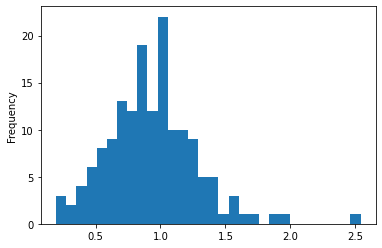

In [71]:
df[df.pred_label_issues_mask]["correctable_score"].plot(kind="hist", bins=30)


Est. Label Issues              : 158
Est. Correctable               : 34

Precision of Est. Label Issues : 0.6582
Precision of Est. Correctable  : 0.7647

% of Est. Correctable w/ Action to Fix Data Label  : 0.47058823529411764
% of Est. Correctable w/ Action to Remove Bad Data : 0.29411764705882354



,display_image,label_errors_target,action,correctable,ood,label_name,top1_pred_label
1533,,True,Fix Data Label,True,False,vi,x
840,,True,Fix Data Label,True,False,ix,iv
1345,,True,Remove Bad Data,True,False,iv,iii
2622,,True,Fix Data Label,True,False,vi,iv
2503,,True,Fix Data Label,True,False,ix,vi
762,,False,Keep Data,True,False,iv,vi
2636,,True,Fix Data Label,True,False,vi,iii
655,,True,Fix Data Label,True,False,ii,x
2104,,True,Fix Data Label,True,False,ii,i
525,,True,Fix Data Label,True,False,x,v

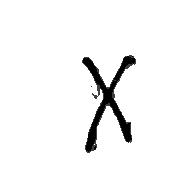
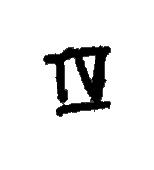
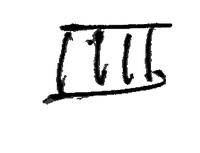
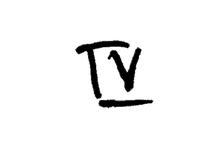
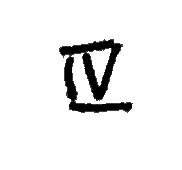
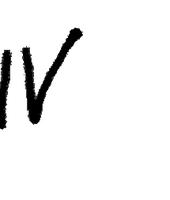
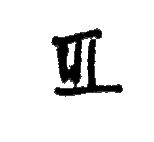
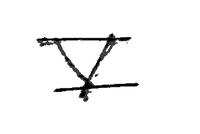
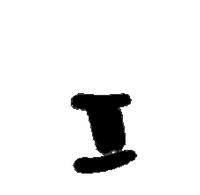
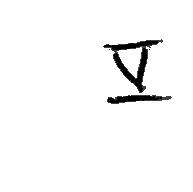
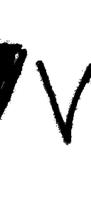
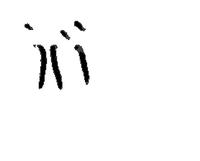
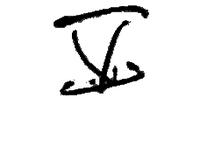
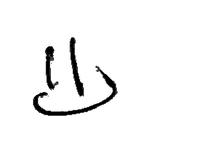
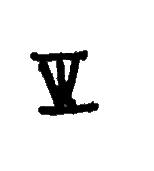
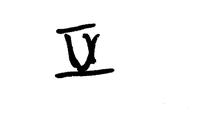
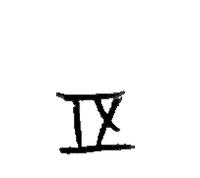
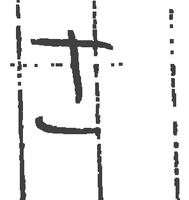
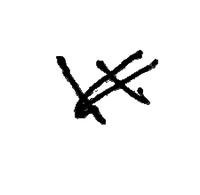
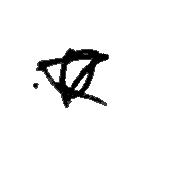
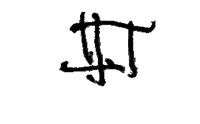
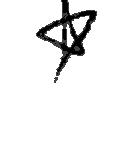
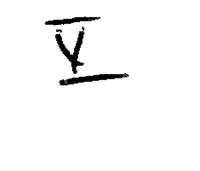
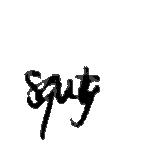
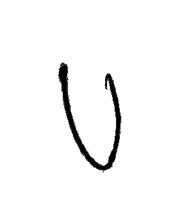
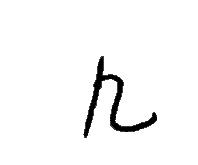
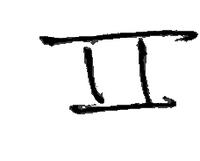
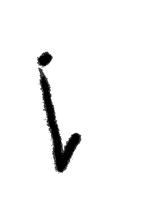
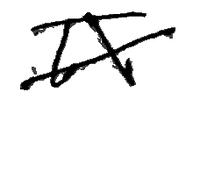
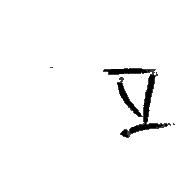
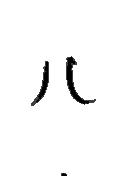
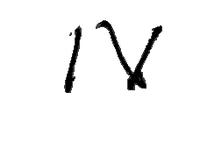
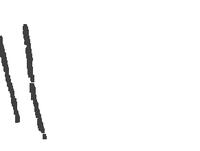
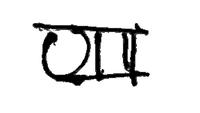

In [77]:
# logic to flag issue type

#### Correctable
C_correctable = 10
# df["correctable"] = df.top1_pred > C_correctable * df.top2_pred
# df["correctable"] = df.normalized_margin < C_correctable * df.normalized_margin.mean()
# df["correctable"] = (df.top2_pred > C_correctable * df.top2_pred.mean()) & (df.top1_pred / df.top2_pred > C_correctable)
# df["correctable"] = df.correctable_score > C_correctable * df.correctable_score.mean()

df["correctable"] = df.correctable_score > C_correctable * np.vectorize(lambda idx: avg_correctable_score_per_class[idx])(labels)

# adjusted score subtracting class thresholds
# df["correctable_score_adj"] = df.correctable_score - np.vectorize(lambda idx: avg_correctable_score_per_class[idx])(labels)

#### Multi-Label
df["multi_label"] = df.top2_pred > df.top1_pred.mean()

#### Out-of-Distribution (OOD)
C_ood = 1.75
# df["ood"] = df.entropy > C_ood * df.entropy.mean()
df["ood"] = df.knn_k10_entropy > C_ood * df.knn_k10_entropy.mean()


# df_rank_filter = df[df.pred_label_issues_mask][df.ood].sort_values(by="ood_score", ascending=False)
df_rank_filter = df[df.pred_label_issues_mask][(df.correctable) & (~df.ood)].sort_values(by="correctable_score", ascending=False)

# df_rank_filter = df[df.pred_label_issues_mask].sort_values(by="correctable_score", ascending=False).head(50)
# df_rank_filter = df[df.pred_label_issues_mask][~df.ood].sort_values(by="correctable_score", ascending=False)


# print evaluation metrics
print()
print(f"Est. Label Issues              : {df.pred_label_issues_mask.sum()}")
print(f"Est. Correctable               : {df_rank_filter.shape[0]}")
print()
print(f"Precision of Est. Label Issues : {round(df[df.pred_label_issues_mask].label_errors_target.mean(), 4)}")
print(f"Precision of Est. Correctable  : {round(df_rank_filter.label_errors_target.mean(), 4)}")
print()
print(f"% of Est. Correctable w/ Action to Fix Data Label  : {df_rank_filter[df_rank_filter.action == 'Fix Data Label'].shape[0] / df_rank_filter.shape[0]}")
print(f"% of Est. Correctable w/ Action to Remove Bad Data : {df_rank_filter[df_rank_filter.action == 'Remove Bad Data'].shape[0] / df_rank_filter.shape[0]}")
print()

HTML(df_rank_filter[columns].to_html(formatters={"display_image": image_formatter}, escape=False))